In [1]:
import numpy as np
from scipy.stats import expon
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
LEARNING_RATE = 0.01
MOMENTUM = 0.9
BATCH_SIZE = 32
NUM_EPOCHS = 10

In [3]:
class LogisticRegression(tf.keras.Model):
    def __init__(self, n_classes, l2_lambda=0.0):
        super().__init__()
        self.dense = tf.keras.layers.Dense(
            n_classes,
            kernel_initializer=tf.keras.initializers.RandomNormal(),
            kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)
        )

    def call(self, inputs, training=None):
        x = self.dense(inputs)
        x = tf.nn.softmax(x)
        return x

In [4]:
def preprocess(example):
    return tf.reshape(example['image']/255, [-1]), example['label']

train = tfds.load('mnist', split='train').map(preprocess).shuffle(1024).batch(BATCH_SIZE)
test = tfds.load('mnist', split='test').map(preprocess).batch(BATCH_SIZE)

In [5]:
def get_train_step():
    @tf.function
    def train_step(model, inputs, labels, criterion, optimizer, metrics):
        with tf.GradientTape() as tape:
            outputs = model(inputs, training=True)
            loss = criterion(labels, outputs) + tf.reduce_sum(model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        metrics['train_loss'].update_state(loss)
        metrics['train_accuracy'].update_state(labels, outputs)
    return train_step

def get_test_step():
    @tf.function
    def test_step(model, inputs, labels, criterion, metrics):
        outputs = model(inputs, training=False)
        loss = criterion(labels, outputs) + tf.reduce_sum(model.losses)
        metrics['test_loss'].update_state(loss)
        metrics['test_accuracy'].update_state(labels, outputs)
    return test_step

metrics = {
    'train_loss': tf.keras.metrics.Mean(name='train_loss'),
    'train_accuracy': tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy'),
    'test_loss': tf.keras.metrics.Mean(name='test_loss'),
    'test_accuracy': tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy'),
}

# Baseline MNIST with underfitting Logistic Regression

Epoch 0: Train Loss=0.4194890558719635, Train Accuracy=0.8835999965667725,
         Test Loss=0.31226059794425964, Test Accuracy=0.9132999777793884
Epoch 1: Train Loss=0.3140457570552826, Train Accuracy=0.9113166928291321,
         Test Loss=0.2895925045013428, Test Accuracy=0.9204000234603882
Epoch 2: Train Loss=0.29759711027145386, Train Accuracy=0.9161499738693237,
         Test Loss=0.2828733026981354, Test Accuracy=0.9196000099182129
Epoch 3: Train Loss=0.288061261177063, Train Accuracy=0.9191833138465881,
         Test Loss=0.2840452194213867, Test Accuracy=0.9204000234603882
Epoch 4: Train Loss=0.2821924090385437, Train Accuracy=0.9213666915893555,
         Test Loss=0.2799644470214844, Test Accuracy=0.9218999743461609
Epoch 5: Train Loss=0.27754512429237366, Train Accuracy=0.9228666424751282,
         Test Loss=0.2756660282611847, Test Accuracy=0.9211999773979187
Epoch 6: Train Loss=0.27452296018600464, Train Accuracy=0.9230666756629944,
         Test Loss=0.2746399939060211, T

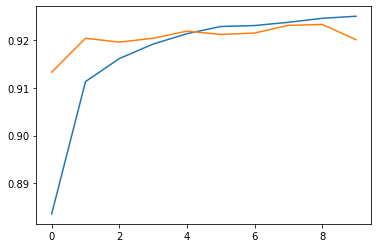

In [6]:
model = LogisticRegression(10)
criterion = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(LEARNING_RATE, MOMENTUM)

train_step = get_train_step()
test_step = get_test_step()

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(NUM_EPOCHS):
    
    for metric in metrics:
        metrics[metric].reset_states()
    
    for inputs, labels in train:
        train_step(model, inputs, labels, criterion, optimizer, metrics)
        
    for inputs, labels in test:
        test_step(model, inputs, labels, criterion, metrics)
    
    train_loss.append(metrics['train_loss'].result())
    train_accuracy.append(metrics['train_accuracy'].result())
    test_loss.append(metrics['test_loss'].result())
    test_accuracy.append(metrics['test_accuracy'].result())
    
    print(
        f'Epoch {epoch}: Train Loss={train_loss[-1]}, Train Accuracy={train_accuracy[-1]},\n \
        Test Loss={test_loss[-1]}, Test Accuracy={test_accuracy[-1]}'
    )
    
plt.plot(train_accuracy)
plt.plot(test_accuracy)

In [7]:
def resample_dataset(dataset, density, training=False):
    all_inputs = []
    all_labels = []
    resampled_inputs = []
    resampled_labels = []
    
    for inputs, labels in dataset:
        all_inputs.append(inputs)
        all_labels.append(labels)
        
    all_inputs = np.vstack(all_inputs)
    all_labels = np.hstack(all_labels)
    
    for digit, p_digit in enumerate(density):
        print(f'{digit}: {p_digit}')
        index = np.where(all_labels == digit)[0]
        index = index[:int(len(index)*p_digit)]
        resampled_inputs.append(all_inputs[index])
        resampled_labels.append(all_labels[index])
        
    dataset = tf.data.Dataset.from_tensor_slices(
        (np.vstack(resampled_inputs), np.hstack(resampled_labels))
    )

    if training:
        return dataset.shuffle(1024).batch(BATCH_SIZE)
    else:
        return dataset.batch(BATCH_SIZE)

density, _ = np.histogram(expon.rvs(scale=1/0.5, size=1000), bins=range(11), density=True)

# Exponentially resampled MNIST with stationary train/test

0: 0.2462159434914228
1: 0.09384460141271443
2: 0.022199798183652877
3: 0.13319878910191726
4: 0.03128153380423814
5: 0.04843592330978809
6: 0.4036326942482341
7: 0.004036326942482341
8: 0.013118062563067608
9: 0.004036326942482341
0: 0.2462159434914228
1: 0.09384460141271443
2: 0.022199798183652877
3: 0.13319878910191726
4: 0.03128153380423814
5: 0.04843592330978809
6: 0.4036326942482341
7: 0.004036326942482341
8: 0.013118062563067608
9: 0.004036326942482341
Epoch 0: Train Loss=0.6033169627189636, Train Accuracy=0.8498749136924744,
         Test Loss=0.48994550108909607, Test Accuracy=0.8380855321884155
Epoch 1: Train Loss=0.2600463032722473, Train Accuracy=0.925437867641449,
         Test Loss=0.343343049287796, Test Accuracy=0.8981670141220093
Epoch 2: Train Loss=0.21239349246025085, Train Accuracy=0.9371142387390137,
         Test Loss=0.3277154564857483, Test Accuracy=0.9002036452293396
Epoch 3: Train Loss=0.18405140936374664, Train Accuracy=0.9454545378684998,
         Test Loss=

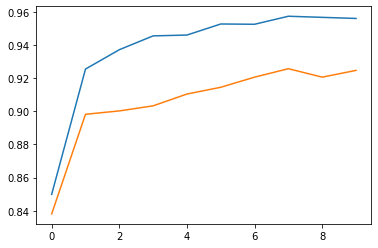

In [8]:
model = LogisticRegression(10)
criterion = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(LEARNING_RATE, MOMENTUM)

train_step = get_train_step()
test_step = get_test_step()

train_density = np.random.permutation(density)
resampled_train = resample_dataset(train, train_density, training=True)
resampled_test = resample_dataset(test, train_density, training=False)

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(NUM_EPOCHS):
    
    for metric in metrics:
        metrics[metric].reset_states()
    
    for inputs, labels in resampled_train:
        train_step(model, inputs, labels, criterion, optimizer, metrics)
        
    for inputs, labels in resampled_test:
        test_step(model, inputs, labels, criterion, metrics)
    
    train_loss.append(metrics['train_loss'].result())
    train_accuracy.append(metrics['train_accuracy'].result())
    test_loss.append(metrics['test_loss'].result())
    test_accuracy.append(metrics['test_accuracy'].result())
    
    print(
        f'Epoch {epoch}: Train Loss={train_loss[-1]}, Train Accuracy={train_accuracy[-1]},\n \
        Test Loss={test_loss[-1]}, Test Accuracy={test_accuracy[-1]}'
    )
    
plt.plot(train_accuracy)
plt.plot(test_accuracy)

# Exponentially resampled MNIST with shifted train/test

0: 0.04843592330978809
1: 0.03128153380423814
2: 0.4036326942482341
3: 0.09384460141271443
4: 0.13319878910191726
5: 0.004036326942482341
6: 0.013118062563067608
7: 0.022199798183652877
8: 0.2462159434914228
9: 0.004036326942482341
0: 0.09384460141271443
1: 0.013118062563067608
2: 0.4036326942482341
3: 0.13319878910191726
4: 0.004036326942482341
5: 0.04843592330978809
6: 0.03128153380423814
7: 0.2462159434914228
8: 0.022199798183652877
9: 0.004036326942482341
Epoch 0: Train Loss=0.6699820756912231, Train Accuracy=0.8301981687545776,
         Test Loss=1.121687412261963, Test Accuracy=0.6180555820465088
Epoch 1: Train Loss=0.32160425186157227, Train Accuracy=0.9035941958427429,
         Test Loss=0.7540347576141357, Test Accuracy=0.77182537317276
Epoch 2: Train Loss=0.2668326199054718, Train Accuracy=0.9198858141899109,
         Test Loss=0.7696735858917236, Test Accuracy=0.7658730149269104
Epoch 3: Train Loss=0.24192039668560028, Train Accuracy=0.928787350654602,
         Test Loss=0.7

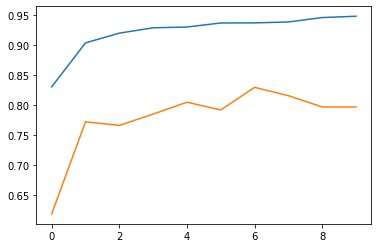

In [9]:
model = LogisticRegression(10)
criterion = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(LEARNING_RATE, MOMENTUM)

train_step = get_train_step()
test_step = get_test_step()

train_density = np.random.permutation(density)
test_density = np.random.permutation(density)
resampled_train = resample_dataset(train, train_density, training=True)
resampled_test = resample_dataset(test, test_density, training=False)

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []


for epoch in range(NUM_EPOCHS):
    
    for metric in metrics:
        metrics[metric].reset_states()
    
    for inputs, labels in resampled_train:
        train_step(model, inputs, labels, criterion, optimizer, metrics)
        
    for inputs, labels in resampled_test:
        test_step(model, inputs, labels, criterion, metrics)
    
    train_loss.append(metrics['train_loss'].result())
    train_accuracy.append(metrics['train_accuracy'].result())
    test_loss.append(metrics['test_loss'].result())
    test_accuracy.append(metrics['test_accuracy'].result())
    
    print(
        f'Epoch {epoch}: Train Loss={train_loss[-1]}, Train Accuracy={train_accuracy[-1]},\n \
        Test Loss={test_loss[-1]}, Test Accuracy={test_accuracy[-1]}'
    )
    
plt.plot(train_accuracy)
plt.plot(test_accuracy)

In [10]:
def confusion_matrix(model, dataset):
    all_labels = []
    all_predictions = []

    for inputs, labels in dataset:
        outputs = model(inputs, training=False)
        all_labels.append(labels)
        all_predictions.append(tf.argmax(outputs, axis=1))
    
    return tf.math.confusion_matrix(
        np.hstack(all_labels), np.hstack(all_predictions)
    )